In [1]:
import torch
import torch.optim as optim
from torch.utils.data import DataLoader

from torch.distributions import normal

import time

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

# libraries from bliss 
from bliss.models import encoder
from bliss.datasets import sdss

# utils unique to this experiment
import sys
sys.path.insert(0, './utils')

from encoder_lib import MLPEncoder
from dataset_lib import CenteredStarsData, trim_psf
from which_device import device


print(device)


cuda:4


# Create dataset

### The psf

In [2]:
sdss_dir = '/home/runingli/astronomy/celeste/data/sdss/'
psf_file = sdss_dir + '/94/1/12/psField-000094-1-0012.fits'

In [3]:
sdss_psf = sdss.SdssPSF(psf_file, [2])
psf = sdss_psf.psf_at_points(0, 0., 0.)

# convert to torch tensor
psf = torch.Tensor(psf).to(device)

# trim the psf
slen = 11
psf = trim_psf(psf, slen)

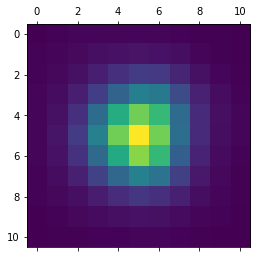

In [4]:
%matplotlib inline

plt.matshow(psf.cpu().numpy())

### the dataset: just centered stars

In [5]:
n_images = 20000
star_data = CenteredStarsData(psf, 
                              n_images = n_images)

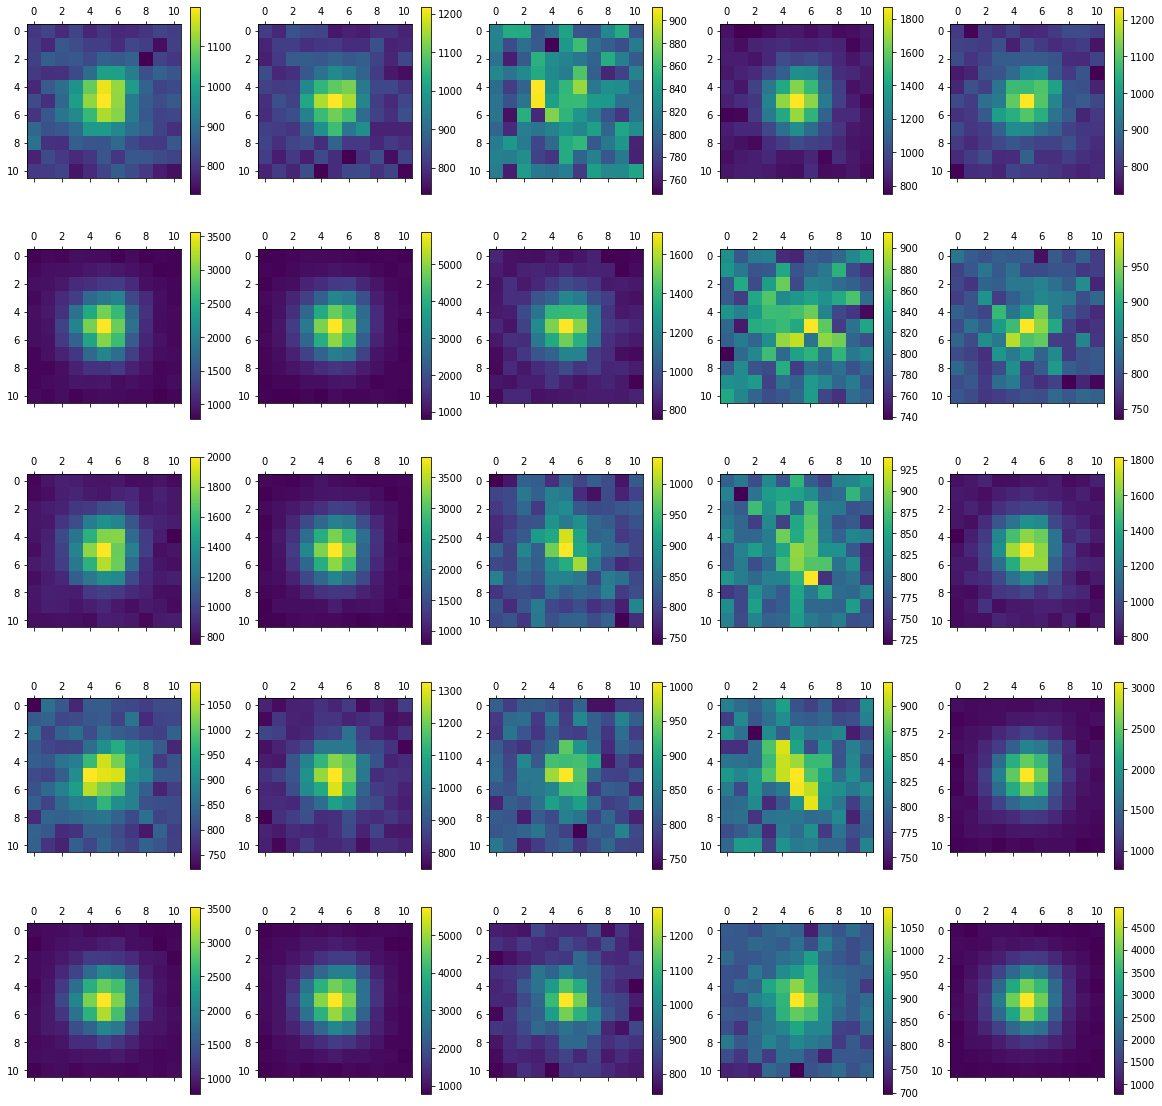

In [6]:
fig, ax = plt.subplots(5, 5, figsize=(20, 20))

for i in range(25): 
        
    x0 = i // 5
    x1 = i % 5
    
    image = star_data[i]['image']
    
    im = ax[x0, x1].matshow(image[0].cpu())
    
    fig.colorbar(im, ax = ax[x0, x1])


# Define neural network

In [7]:
network = MLPEncoder(slen = slen).to(device)
network

MLPEncoder(
  (fc1): Linear(in_features=121, out_features=64, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=64, out_features=2, bias=True)
)

# Define dataset

In [8]:
batch_size = 64
data_loader = DataLoader(star_data, 
                         batch_size=batch_size)

# Define loss

### Sleep phase loss: KL(p, q), with log-normal distribution

In [9]:
def klpq_logspace(network, batch): 
    
    images = batch['image']
    fluxes = batch['flux'].squeeze()
    
    logflux = torch.log(fluxes)
    
    mean, sd = network(images)
    
    return (mean - logflux)**2
    
    # norm = normal.Normal(loc = mean, scale = sd)
    
    # return - norm.log_prob(logflux)

# Train 

In [10]:
for _, batch in enumerate(data_loader):
    break

In [11]:
# initial loss 
loss = klpq_logspace(network, batch).mean()
print('initial loss: {}'.format(loss))

initial loss: 23761.625


In [12]:
optimizer = optim.Adam(network.parameters(), 
                       lr = 1e-3)

In [13]:
n_epochs = 60

In [14]:
network.train()
t0 = time.time() 

for epoch in range(n_epochs): 
    
    avg_loss = 0.
    
    for _, batch in enumerate(data_loader):
        
        optimizer.zero_grad()
        
        loss = klpq_logspace(network, batch).mean()
        loss.backward()
        
        optimizer.step()

        avg_loss += loss 
        
    print('epoch [{}]. loss = {}'.format(epoch, avg_loss / len(data_loader)))

print('done. Elapsed {:.03f}sec'.format(time.time() - t0))

epoch [0]. loss = 356.2757873535156
epoch [1]. loss = 48.320369720458984
epoch [2]. loss = 46.345603942871094
epoch [3]. loss = 51.43171310424805
epoch [4]. loss = 41.587257385253906
epoch [5]. loss = 38.11463165283203
epoch [6]. loss = 32.237144470214844
epoch [7]. loss = 31.258033752441406
epoch [8]. loss = 16.094541549682617
epoch [9]. loss = 23.763099670410156
epoch [10]. loss = 17.16082191467285
epoch [11]. loss = 18.95748519897461
epoch [12]. loss = 11.38936710357666
epoch [13]. loss = 10.28034496307373
epoch [14]. loss = 13.233619689941406
epoch [15]. loss = 10.467891693115234
epoch [16]. loss = 5.384551525115967
epoch [17]. loss = 6.690253257751465
epoch [18]. loss = 7.026193141937256
epoch [19]. loss = 9.250578880310059
epoch [20]. loss = 3.112478256225586
epoch [21]. loss = 4.709362030029297
epoch [22]. loss = 4.091080188751221
epoch [23]. loss = 4.461508274078369
epoch [24]. loss = 3.4808361530303955
epoch [25]. loss = 2.004793405532837
epoch [26]. loss = 2.744495391845703
e

In [15]:
# final loss
network.eval()
loss = klpq_logspace(network, batch).mean()
print('final loss: {}'.format(loss))

final loss: 0.03950706869363785


In [16]:
for _, batch in enumerate(data_loader):
    break

In [17]:
true_fluxes = batch['flux']

means, sd = network(batch['image'])

In [21]:
sd

tensor([2.0301e+13, 4.7353e+36, 2.3650e+24, 4.5109e-04, 5.2818e+37, 1.9058e+37,
               inf,        inf, 8.9297e+36, 5.4215e+20, 6.7394e+35, 1.1306e+33,
               inf,        inf, 5.2055e+34,        inf, 2.5889e+13, 9.4160e+35,
        7.7251e+36,        inf,        inf, 1.3660e+32, 1.2661e+37,        inf,
               inf, 8.8664e+35, 5.0643e+37, 6.7512e+36,        inf,        inf,
        2.2625e+38,        inf, 3.8896e+31, 3.7346e+36, 2.5508e+32, 8.1990e+22,
        2.2973e+38, 1.6297e+21,        inf,        inf,        inf,        inf,
        1.0571e+36, 3.3431e+36, 3.3940e+37,        inf,        inf, 2.2115e+32,
               inf,        inf,        inf, 3.4836e+30, 3.2016e+37,        inf,
        7.7450e+31, 5.7197e+17, 1.5595e+37, 1.0676e+36,        inf, 9.1120e+32,
        5.1246e+25,        inf, 7.3769e+37,        inf], device='cuda:4',
       grad_fn=<ExpBackward>)

In [22]:
# plt.hist(sd.detach().cpu().numpy())

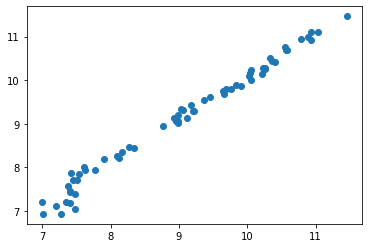

In [23]:
plt.scatter(means.detach().cpu(), 
            np.log(true_fluxes.cpu()))